# Import Required Libraries    

In [35]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm



# 1. Simulate complete dataset with predictors

In [36]:
def sim_dat(n=500, npred=2, seed=1):
    np.random.seed(seed)
    mu = [0] * (npred + 1)
    Sigma = np.ones((npred + 1, npred + 1)) * 0.5
    np.fill_diagonal(Sigma, 1.5)
    dat = np.random.multivariate_normal(mu, Sigma, n)
    colnames = ['y'] + [f'x{i}' for i in range(1, npred + 1)]
    return pd.DataFrame(dat, columns=colnames)

# 2. Introduce MCAR Missingness

In [37]:
def sim_mcar(dat, p=0.2, seed=1):
    random.seed(seed)
    dat = dat.copy()
    dat['y_missing'] = dat['y']
    missing = random.sample(range(len(dat)), int(len(dat) * p))
    dat.loc[missing, 'y_missing'] = np.nan
    return dat

# 3. Introduce MAR Missingness

In [38]:
def sim_mar(dat, p=0.2, seed=1):
    np.random.seed(seed)
    dat = dat.copy()
    dat['y_missing'] = dat['y']
    ordering = np.argsort(dat['x1'] + np.random.normal(size=len(dat)))
    selected = dat.iloc[ordering[:int(p * len(dat))]]
    dat.loc[selected.index, 'y_missing'] = np.nan
    return dat

# Generate complete data

In [39]:
dat_full = sim_dat()

# 4. Handle MCAR with Mean Impute

In [40]:
dat_mcar = sim_mcar(dat_full, p=0.2, seed=1)
dat_mcar['y_imputed_mean'] = dat_mcar['y_missing'].copy()
dat_mcar['y_imputed_mean'] = dat_mcar['y_imputed_mean'].fillna(dat_mcar['y_missing'].mean())

# Handle MCAR with Regression Impute

In [41]:

model_reg_mcar = smf.ols('y_missing ~ x1 + x2', data=dat_mcar).fit()
preds_mcar = model_reg_mcar.predict(dat_mcar[['x1', 'x2']])

dat_mcar['y_imputed_reg'] = dat_mcar['y_missing'].copy()
missing_mcar = dat_mcar['y_missing'].isna()
dat_mcar.loc[missing_mcar, 'y_imputed_reg'] = preds_mcar[missing_mcar]


# 5. Handle MAR with Regression

In [42]:
dat_mar = sim_mar(dat_full, p=0.2, seed=1)

# Regression Imputation
model_reg = smf.ols('y_missing ~ x1 + x2', data=dat_mar).fit()
preds = model_reg.predict(dat_mar[['x1', 'x2']])
dat_mar['y_imputed_reg'] = dat_mar['y_missing'].copy()
missing = dat_mar['y_missing'].isna()
dat_mar.loc[missing, 'y_imputed_reg'] = preds[missing]

# Mean Imputation
dat_mar['y_imputed_mean'] = dat_mar['y_missing'].copy()
dat_mar['y_imputed_mean'].fillna(dat_mar['y_missing'].mean(), inplace=True)


C:\Users\lukew\AppData\Local\Temp\ipykernel_31364\861973567.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dat_mar['y_imputed_mean'].fillna(dat_mar['y_missing'].mean(), inplace=True)


# 6. Fit Linear Models to All Variations

In [43]:
models = {
    'Full': smf.ols('y ~ x1 + x2', data=dat_full).fit(),
    'MCAR_Missing': smf.ols('y_missing ~ x1 + x2', data=dat_mcar.dropna()).fit(),
    'MCAR_MeanImputed': smf.ols('y_imputed_mean ~ x1 + x2', data=dat_mcar).fit(),
    'MCAR_RegImputed': smf.ols('y_imputed_reg ~ x1 + x2', data=dat_mcar).fit(),
    'MAR_Missing': smf.ols('y_missing ~ x1 + x2', data=dat_mar.dropna()).fit(),
    'MAR_MeanImputed': smf.ols('y_imputed_mean ~ x1 + x2', data=dat_mar).fit(),
    'MAR_RegImputed': smf.ols('y_imputed_reg ~ x1 + x2', data=dat_mar).fit()
}


# 7. Compile Coefficients for Compare

In [47]:
summary_df = pd.DataFrame({
    'Model': [],
    'x1_Coeff': [],
    'x2_Coeff': []
})

for name, model in models.items():
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Model': [name],
        'x1_Coeff': [model.params.get('x1')],
        'x2_Coeff': [model.params.get('x2')]
    })], ignore_index=True)

summary_df['Model'] = pd.Categorical(summary_df['Model'], categories=[
    'Full',
    'MCAR_Missing', 'MCAR_MeanImputed', 'MCAR_RegImputed',
    'MAR_Missing', 'MAR_MeanImputed', 'MAR_RegImputed'
], ordered=True)

summary_df = summary_df.sort_values('Model')
print(summary_df)

              Model  x1_Coeff  x2_Coeff
0              Full  0.226814  0.225022
1      MCAR_Missing  0.236689  0.245410
2  MCAR_MeanImputed  0.179993  0.196507
3   MCAR_RegImputed  0.236689  0.245410
4       MAR_Missing  0.230363  0.241123
5   MAR_MeanImputed  0.127342  0.169304
6    MAR_RegImputed  0.230363  0.241123


# 8. Plotting MCAR vs Full Coefficients

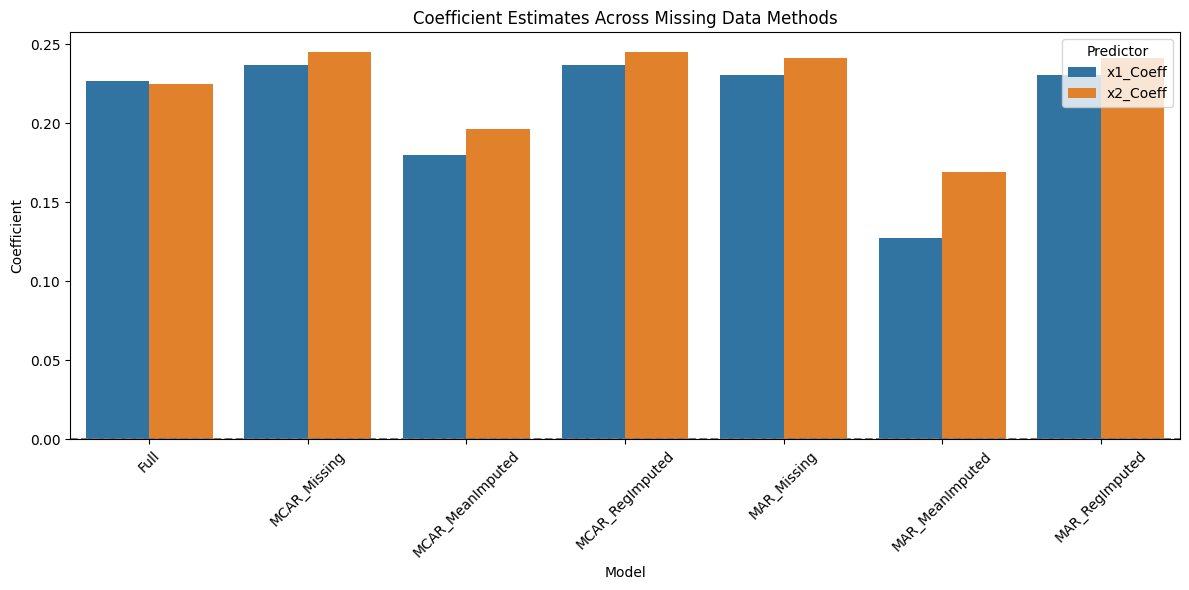

In [45]:

plot_data = summary_df.melt(
    id_vars='Model', value_vars=['x1_Coeff', 'x2_Coeff'],
    var_name='Predictor', value_name='Coefficient'
)

# Plot all in one figure
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data, x='Model', y='Coefficient', hue='Predictor')
plt.title("Coefficient Estimates Across Missing Data Methods")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Conclusion
The coefficient summary table confirms and reinforces the visual findings: mean imputation consistently produces the most biased estimates across both MCAR and MAR conditions. In the full model, the coefficients for x1 and x2 are approximately 0.227 and 0.225, respectively, serving as the benchmark. Under MCAR, listwise deletion (MCAR_Missing) and regression imputation (MCAR_RegImputed) both yield nearly identical coefficients to the full model, suggesting minimal bias when data is missing completely at random and appropriately handled. However, mean imputation (MCAR_MeanImputed) underestimates both x1 (0.180) and x2 (0.197), confirming its tendency to dampen true signal due to variance suppression.

The distortion becomes even more pronounced under MAR. While both MAR_Missing and MAR_RegImputed still produce coefficients close to the full model, MAR_MeanImputed drops sharply to 0.127 for x1 and 0.169 for x2. This clearly illustrates that mean imputation fails to account for the systematic nature of MAR missingness, leading to substantial bias. In contrast, regression imputation under MAR closely matches the true values because it leverages observed predictors to model missing outcomes.

In conclusion, the results provide strong empirical evidence that mean imputation is not a suitable method for handling missing data in statistical modeling. It introduces significant bias, particularly under MAR, and fails to preserve the underlying data structure. Regression-based imputation is a far more reliable approach, producing coefficients that are both accurate and consistent with the full dataset. These insights emphasize the importance of selecting imputation strategies grounded in the assumed missingness mechanism and statistical best practices.